In [ ]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.6/82.6 kB 3.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from boto3 import resource
import numpy as np

In [ ]:
from google.colab import userdata
aws_access_key_id = userdata.get('aws_access_key_id')
aws_secret_access_key = userdata.get('aws_secret_access_key')

In [ ]:
dynamodb = resource('dynamodb',
                    aws_access_key_id=aws_access_key_id,
                    aws_secret_access_key=aws_secret_access_key,
                    region_name='us-east-2')
table = dynamodb.Table('datos_sensados')

Se configura el acceso a la base de datos de DynamoDB de Amazon Web Services usando credenciales de acceso almacenadas. Esta configuración permite conectarse a la tabla datos_sensados desde la cual se recuperarán los datos históricos generados desde los dispositivos IoT a través del tiempo.

In [ ]:
import time

def scan_table_with_limit(table, limit=100000, batch_size=100, delay=1):
    data = []
    exclusive_start_key = None

    while len(data) < limit:
        if exclusive_start_key:
            response = table.scan(
                Limit=batch_size,
                ExclusiveStartKey=exclusive_start_key
            )
        else:
            response = table.scan(
                Limit=batch_size
            )

        if 'Items' in response:
            data.extend(response['Items'])

        if 'LastEvaluatedKey' in response:
            exclusive_start_key = response['LastEvaluatedKey']
        else:
            break

        # Limitar registros
        if len(data) > limit:
            data = data[:limit]
            break

        time.sleep(delay)  # Pausar para no exceder el rendimiento aprovisionado

    return data

# Escanear la tabla y cargar los datos en un DataFrame
data = scan_table_with_limit(table)
df = pd.DataFrame(data)

# Filtrar los datos por idDispositivo
df = df[df['idDispositivo'] == '1C63B7F23A08']

# Convertir las columnas relevantes a numérico
df[['h', 't', 'c', 'v']] = df[['h', 't', 'c', 'v']].apply(pd.to_numeric)

# Verificar y eliminar filas con valores faltantes
df = df.dropna(subset=['h', 't', 'c', 'v'])

La función scan_table_with_limit escanea la tabla DynamoDB en lotes, respetando un límite de datos y un tamaño de lote específico, con la finalidad de no alcanzar el limite de aprovisionamiento, lo que ocasiona el abortar el escaneo de datos. Los datos se acumulan y se almacenan en un DataFrame de Pandas para un posterior análisis de datos. Esto es esencial para manejar grandes volúmenes de datos sin exceder los límites de rendimiento de DynamoDB. Asimismo, se filtran los datos para incluir solo aquellos del dispositivo específico 1C63B7F23A08 después de haber realizado la calibración de los sensores que contiene y se convierten las columnas relevantes a valores numéricos. Luego, se eliminan las filas con valores nulos para asegurar la integridad de los datos.

In [ ]:
df

,c,idDispositivo,fh,t,v,h
0,1560.0,1C63B7F23A08,1719486931632,25.100000,182.0,36.200001
1,486.0,1C63B7F23A08,1718516833844,28.299999,13.0,44.200001
2,444.0,1C63B7F23A08,1718611385642,27.700001,6.0,43.200001
3,568.0,1C63B7F23A08,1722880787502,25.500000,18.0,44.200001
4,1441.0,1C63B7F23A08,1718796018656,27.299999,158.0,42.200001
...,...,...,...,...,...,...
99967,460.0,1C63B7F23A08,1718580022180,28.299999,9.0,40.200001
99991,545.0,1C63B7F23A08,1719257089108,26.000000,22.0,47.200001
99993,1513.0,1C63B7F23A08,1718774765551,27.700001,180.0,42.200001
99995,848.0,1C63B7F23A08,1724107527184,26.000000,61.0,46.200001


A continuación se hace la implementación del filtro de Kalman con el fin de filtrar variaciones muy bruscas de las variables ambientales, asimismo obtener mejores resultados.

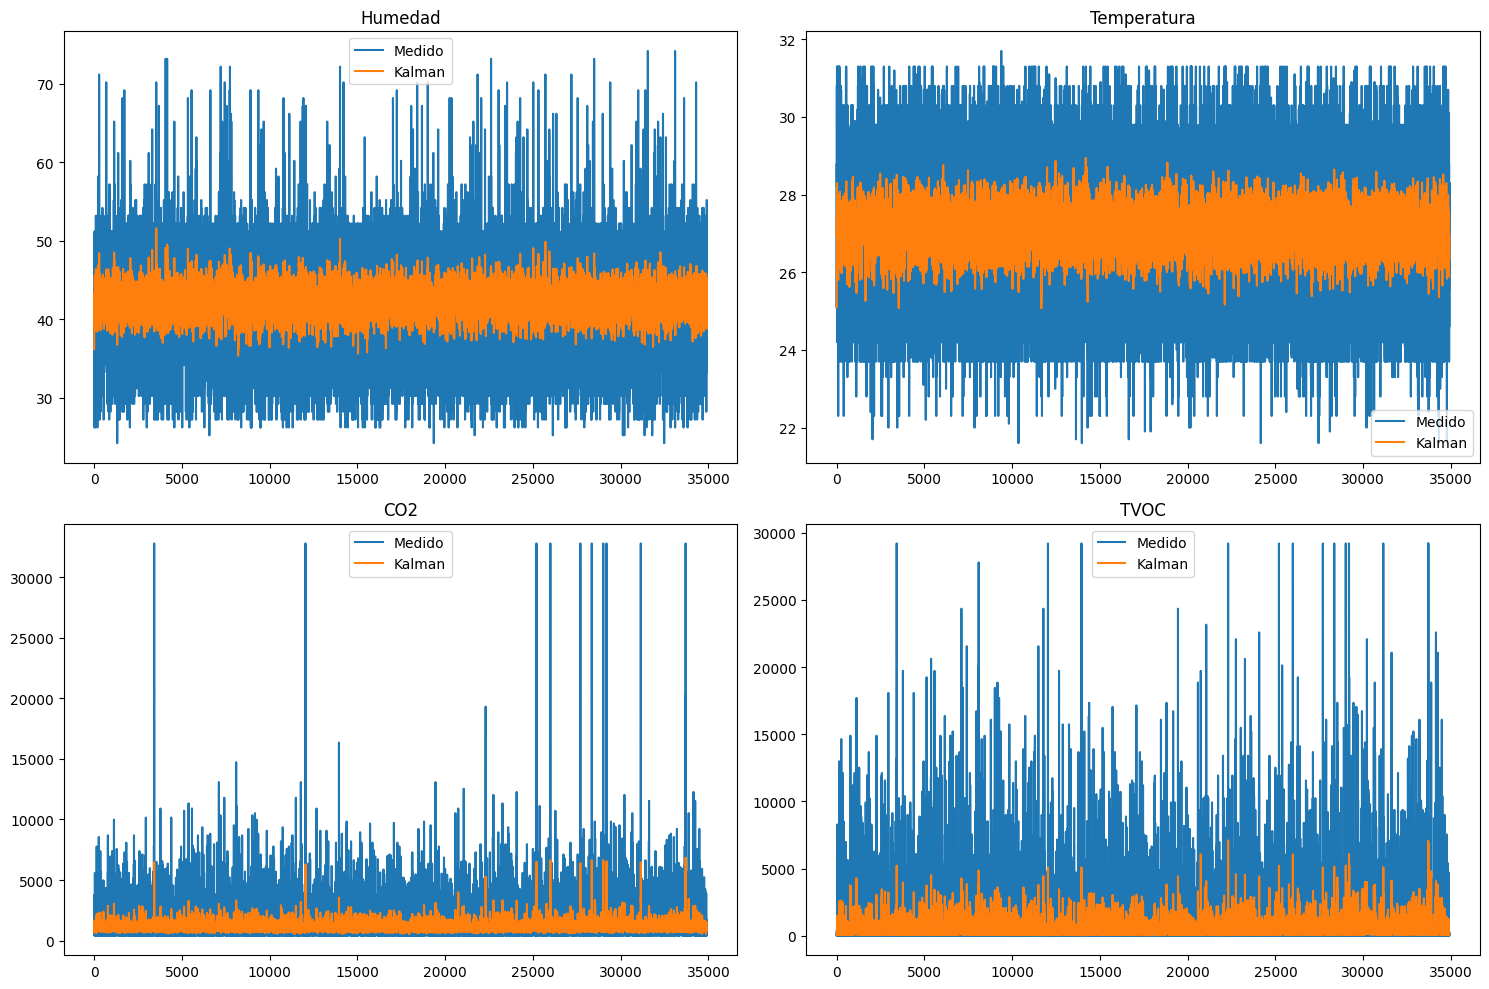

In [ ]:
# @title Filtro de Kalman

from decimal import Decimal, getcontext

def apply_kalman_filter(data, Q=Decimal('0.022'), R=Decimal('0.617')):
    n_iter = len(data)
    sz = (n_iter,)  # Tamaño del array
    xhat = np.zeros(sz, dtype=np.float64)      # a posteriori estimate of x
    P = np.zeros(sz, dtype=np.float64)         # a posteriori error estimate
    xhatminus = np.zeros(sz, dtype=np.float64) # a priori estimate of x
    Pminus = np.zeros(sz, dtype=np.float64)    # a priori error estimate
    K = np.zeros(sz, dtype=np.float64)         # gain or blending factor

    # Valores iniciales
    xhat[0] = float(data[0])  # Convertir el primer dato a float
    P[0] = 1.0

    for k in range(1, n_iter):
        # Predicción
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1] + float(Q)

        # Actualización
        K[k] = Pminus[k] / (Pminus[k] + float(R))
        xhat[k] = xhatminus[k] + K[k] * (float(data[k]) - xhatminus[k])
        P[k] = (1 - K[k]) * Pminus[k]

    return xhat

# Reiniciar el índice del DataFrame
df = df.reset_index(drop=True)

# Aplicar el filtro de Kalman a cada columna
df['h_kalman'] = apply_kalman_filter(df['h'])
df['t_kalman'] = apply_kalman_filter(df['t'])
df['c_kalman'] = apply_kalman_filter(df['c'])
df['v_kalman'] = apply_kalman_filter(df['v'])

# Visualizar los resultados
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(df['h'].astype(float), label='Medido')
plt.plot(df['h_kalman'], label='Kalman')
plt.title('Humedad')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(df['t'].astype(float), label='Medido')
plt.plot(df['t_kalman'], label='Kalman')
plt.title('Temperatura')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(df['c'].astype(float), label='Medido')
plt.plot(df['c_kalman'], label='Kalman')
plt.title('CO2')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(df['v'].astype(float), label='Medido')
plt.plot(df['v_kalman'], label='Kalman')
plt.title('TVOC')
plt.legend()

plt.tight_layout()
plt.show()

Despues de generar un dataset con mediciones del dispositivo 1C63B7F23A08 posteriormente a la calibración de los sensores se implementa el filtro de Kalman a las variables humedad (h), temperatura (t), CO2 (c) y TVOC (v). El filtro de Kalman es un modelo matemático que ayuda a suavizar los datos ruidosos de un dataset, proporcionando estimaciones más precisas y reales de las variables sensadas, asimismo se visualizan los datos originales junto con los datos filtrados por Kalman. Esto permite comparar y verificar la efectividad del filtro de Kalman en la suavización de las mediciones ruidosas.

La columna fh hace referencia al timestamp, el cual es a cantidad de milisegundos a partir del 1 de enero de 1970 a las 0:00, en este único valor es posible almacenar fecha y hora en que llego un registro historico, por lo tanto, es necesario implementar una conversión a fecha y hora yy/mm/dd, hh/mm/ss para obtener resultados más comprehensibles.

In [ ]:
#from datetime import datetime
# Convertir la columna de timestamp a un formato de fecha y hora entendible
# Dividir por 1000 para convertir de milisegundos a segundos
#df['fh'] = pd.to_datetime(df['fh'].astype(int) // 1000, unit='s')

import pandas as pd
from datetime import datetime

# Filtrar valores fuera del rango permitido
valid_timestamps = (df['fh'] // 1000 > 0) & (df['fh'] // 1000 < 253402300799)  # 253402300799 es el timestamp para 9999-12-31 23:59:59
df = df[valid_timestamps]

# Convertir los timestamps válidos a fecha y hora
df['fh'] = pd.to_datetime(df['fh'].astype(float) // 1000, unit='s', errors='coerce')

print(df)

            c idDispositivo                  fh          t      v          h  \
0      1560.0  1C63B7F23A08 2024-06-27 11:15:31  25.100000  182.0  36.200001   
1       486.0  1C63B7F23A08 2024-06-16 05:47:13  28.299999   13.0  44.200001   
2       444.0  1C63B7F23A08 2024-06-17 08:03:05  27.700001    6.0  43.200001   
3       568.0  1C63B7F23A08 2024-08-05 17:59:47  25.500000   18.0  44.200001   
4      1441.0  1C63B7F23A08 2024-06-19 11:20:18  27.299999  158.0  42.200001   
...       ...           ...                 ...        ...    ...        ...   
34912   460.0  1C63B7F23A08 2024-06-16 23:20:22  28.299999    9.0  40.200001   
34913   545.0  1C63B7F23A08 2024-06-24 19:24:49  26.000000   22.0  47.200001   
34914  1513.0  1C63B7F23A08 2024-06-19 05:26:05  27.700001  180.0  42.200001   
34915   848.0  1C63B7F23A08 2024-08-19 22:45:27  26.000000   61.0  46.200001   
34916  1074.0  1C63B7F23A08 2024-06-18 21:15:48  28.299999  102.0  42.200001   

        h_kalman   t_kalman     c_kalma

Se procede a graficar las variables con el filtro aplicado de Kalman, para verificar el nuevo estado de cada una de las variables.

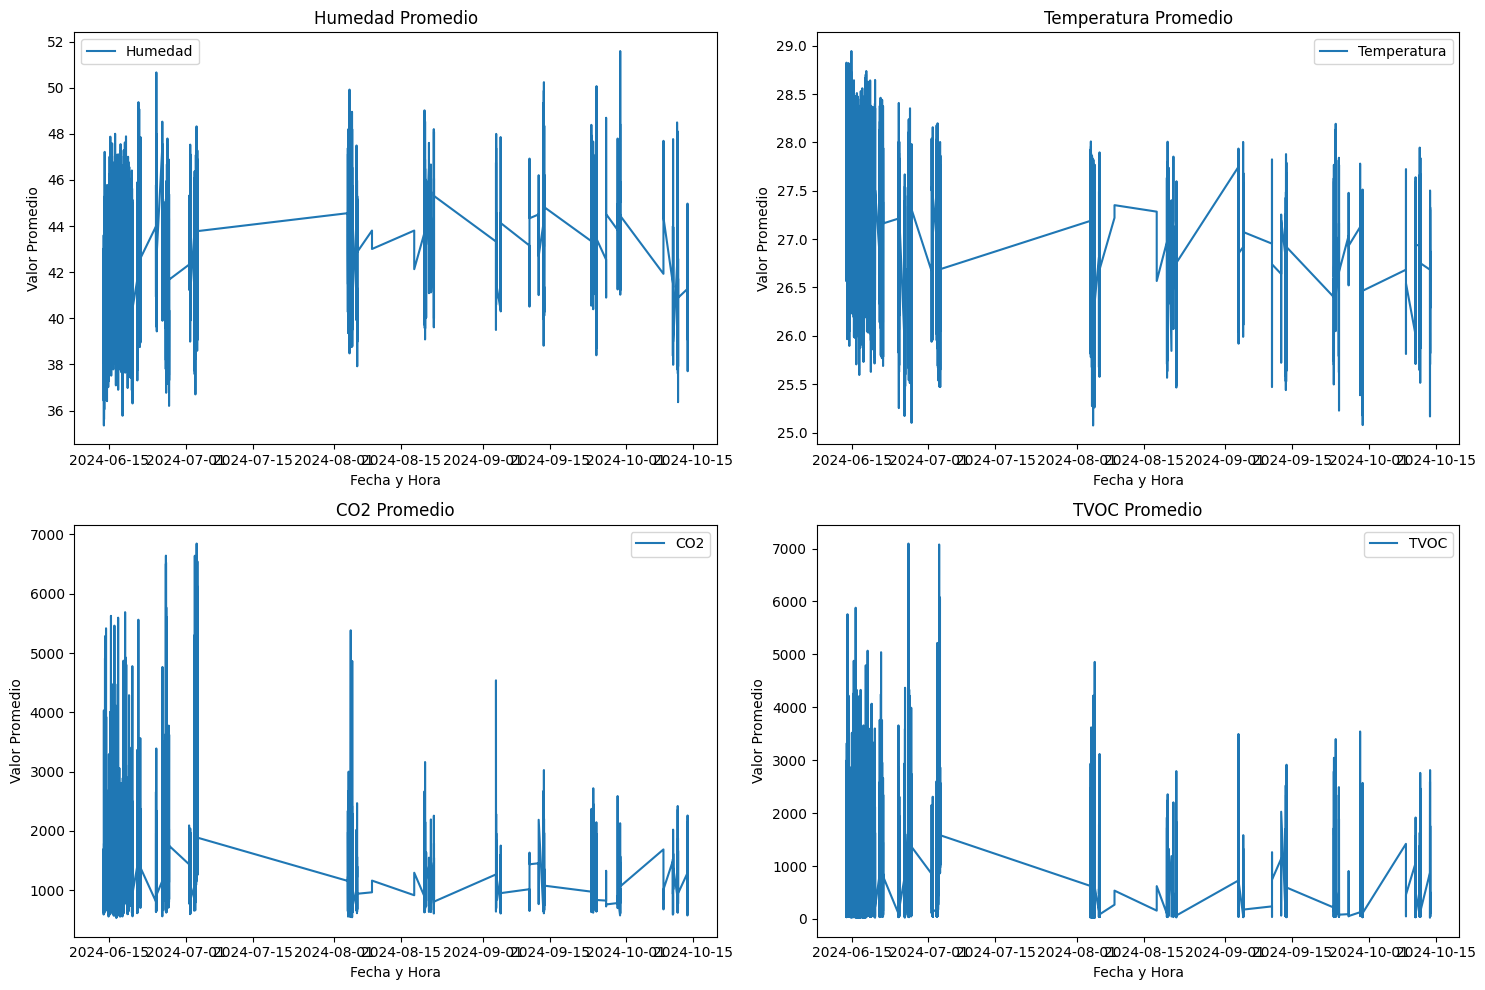

In [ ]:
g = df.groupby('fh')[['h_kalman', 't_kalman', 'c_kalman', 'v_kalman']].mean()
g = g.fillna(g.mean())
g = g.dropna()

# Graficar individualmente cada variable
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(g.index, g['h_kalman'], label='Humedad')
plt.title('Humedad Promedio')
plt.xlabel('Fecha y Hora')
plt.ylabel('Valor Promedio')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(g.index, g['t_kalman'], label='Temperatura')
plt.title('Temperatura Promedio')
plt.xlabel('Fecha y Hora')
plt.ylabel('Valor Promedio')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(g.index, g['c_kalman'], label='CO2')
plt.title('CO2 Promedio')
plt.xlabel('Fecha y Hora')
plt.ylabel('Valor Promedio')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(g.index, g['v_kalman'], label='TVOC')
plt.title('TVOC Promedio')
plt.xlabel('Fecha y Hora')
plt.ylabel('Valor Promedio')
plt.legend()

plt.tight_layout()
plt.show()

Se calcula y visualiza la matriz de correlación entre las variables con el filtro de Kalman aplicado, mostrando la relación entre ellas. Esto ayuda a entender cómo las variables están interrelacionadas y si alguna de ellas tiene una influencia significativa sobre las demás.

In [ ]:
#@ Matriz de correlación

correlation_matrix = df[['h_kalman', 't_kalman', 'c_kalman', 'v_kalman']].corr()
correlation_matrix

,h_kalman,t_kalman,c_kalman,v_kalman
h_kalman,1.000000,-0.624760,0.006150,0.087473
t_kalman,-0.624760,1.000000,-0.111452,-0.175787
c_kalman,0.006150,-0.111452,1.000000,0.921350
v_kalman,0.087473,-0.175787,0.921350,1.000000


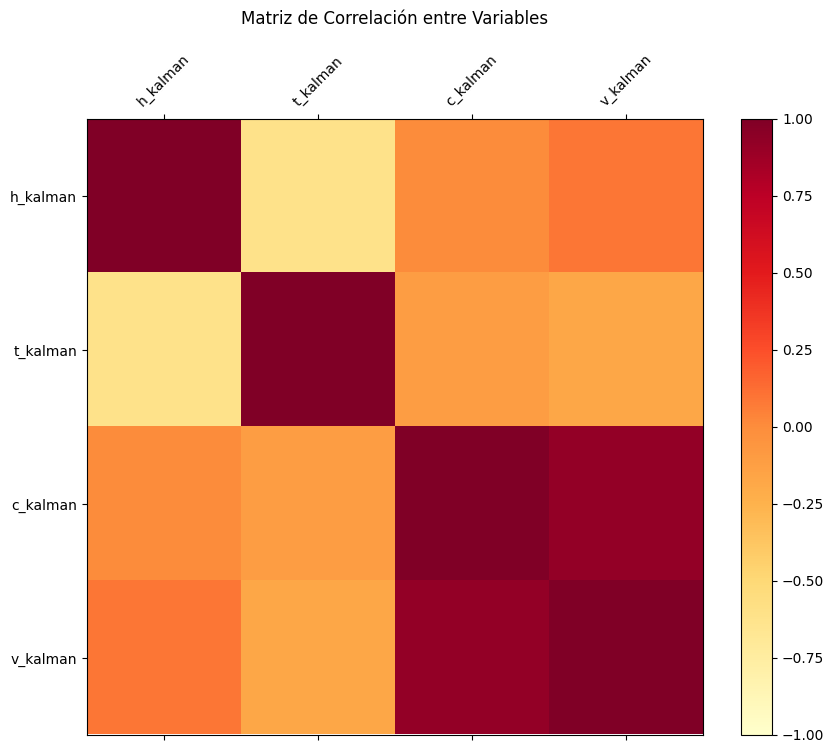

In [ ]:
# Crear un heatmap con pandas

fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(correlation_matrix, cmap='YlOrRd', vmin=-1, vmax=1)
fig.colorbar(cax)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Matriz de Correlación entre Variables', pad=20)
plt.show()

Se realiza una regresión lineal simple para cada variable (h_kalman, t_kalman, c_kalman, v_kalman). Las predicciones se comparan con los valores reales, mostrando la capacidad del modelo para predecir cada variable en función del tiempo. Las regresiones lineales simples muestran cómo cada variable sensada cambia con el tiempo. Las predicciones generadas por los modelos se comparan con los valores reales, permitiendo evaluar la precisión de la regresión lineal en la captura de tendencias temporales. Generalmente, se observa que las predicciones siguen la tendencia general de los datos, aunque pueden no capturar todas las fluctuaciones.

Análisis h_kalman

R-cuadrado: Un valor de 0.002 indica que el modelo explica solo el 0.2% de la variabilidad en la variable dependiente (y), lo que sugiere que h_kalman tiene una influencia mínima.

Coeficiente de h_kalman: El coeficiente es 2.356×10−172.356×10−17, lo que indica una relación directa extremadamente pequeña con la variable dependiente.

Durbin-Watson: Un valor de 1.383 sugiere una ligera autocorrelación positiva en los residuos.

Normalidad de los Residuos: La prueba de Omnibus y Jarque-Bera indican que los residuos no siguen una distribución normal, con una ligera asimetría (skew) de -0.174 y una kurtosis cercana a 3.

Análisis t_kalman

R-cuadrado: Un valor negativo indica que el modelo no es útil para predecir la variable dependiente. De hecho, un R-cuadrado negativo sugiere que el modelo es peor que la media de la variable dependiente.

Coeficiente de t_kalman: El coeficiente es 1.619×10−171.619×10−17, lo que muestra una relación directa extremadamente pequeña con la variable dependiente.

Durbin-Watson: Un valor de 1.346 sugiere una ligera autocorrelación positiva en los residuos.

Normalidad de los Residuos: La prueba de Omnibus y Jarque-Bera también indican que los residuos no siguen una distribución normal, con una ligera asimetría (skew) de -0.285 y una kurtosis mayor a 3 (3.410).

Análisis c_kalman

R-cuadrado: Un valor de 0.000 indica que el modelo no explica ninguna variabilidad en la variable dependiente.

Coeficiente de c_kalman: El coeficiente es 5.717×10−165.717×10−16, lo que muestra una relación directa extremadamente pequeña con la variable dependiente.

Durbin-Watson: Un valor de 1.527 sugiere una ligera autocorrelación positiva en los residuos.

Normalidad de los Residuos: La prueba de Omnibus y Jarque-Bera indican que los residuos no siguen una distribución normal, con una fuerte asimetría (skew) de 10.249 y una kurtosis extremadamente alta (202.619).

Análisis v_kalman

R-cuadrado: Un valor de 0.000 indica que el modelo no explica ninguna variabilidad en la variable dependiente.

Coeficiente de v_kalman: El coeficiente es 7.451×10−177.451×10−17, lo que muestra una relación directa extremadamente pequeña con la variable dependiente.

Durbin-Watson: Un valor de 1.613 sugiere una ligera autocorrelación positiva en los residuos.

Normalidad de los Residuos: La prueba de Omnibus y Jarque-Bera indican que los residuos no siguen una distribución normal, con una fuerte asimetría (skew) de 16.774 y una kurtosis extremadamente alta (380.179).

Regresión Lineal Simple para h_kalman:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 15 Oct 2024   Prob (F-statistic):                nan
Time:                        17:39:11   Log-Likelihood:                -67961.
No. Observations:               34917   AIC:                         1.359e+05
Df Residuals:                   34916   BIC:                         1.359e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1

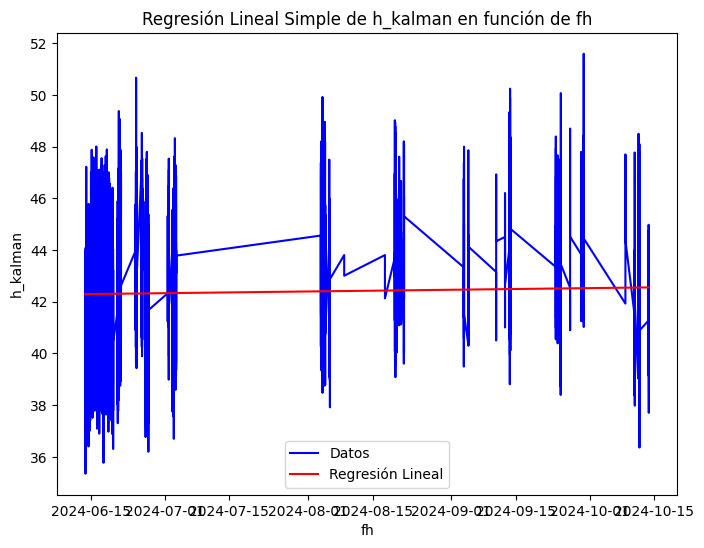

Regresión Lineal Simple para t_kalman:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                      -0.068
Model:                            OLS   Adj. R-squared:                 -0.068
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 15 Oct 2024   Prob (F-statistic):                nan
Time:                        17:39:12   Log-Likelihood:                -26384.
No. Observations:               34917   AIC:                         5.277e+04
Df Residuals:                   34916   BIC:                         5.278e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9

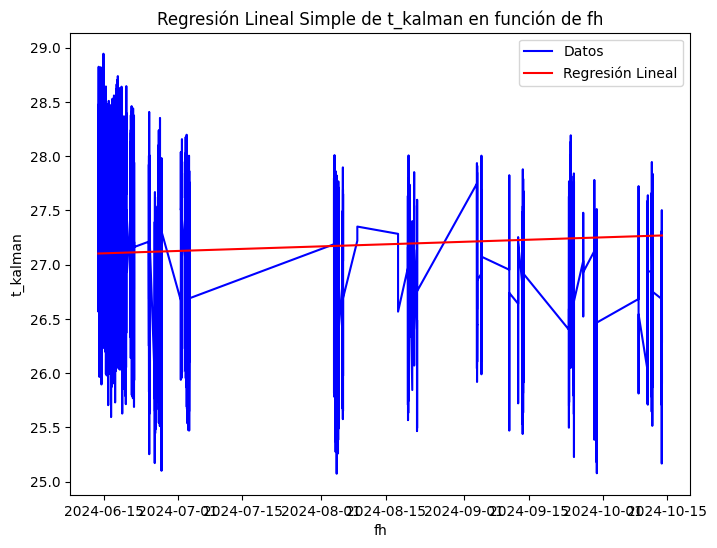

Regresión Lineal Simple para c_kalman:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 15 Oct 2024   Prob (F-statistic):                nan
Time:                        17:39:12   Log-Likelihood:            -2.5554e+05
No. Observations:               34917   AIC:                         5.111e+05
Df Residuals:                   34916   BIC:                         5.111e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3

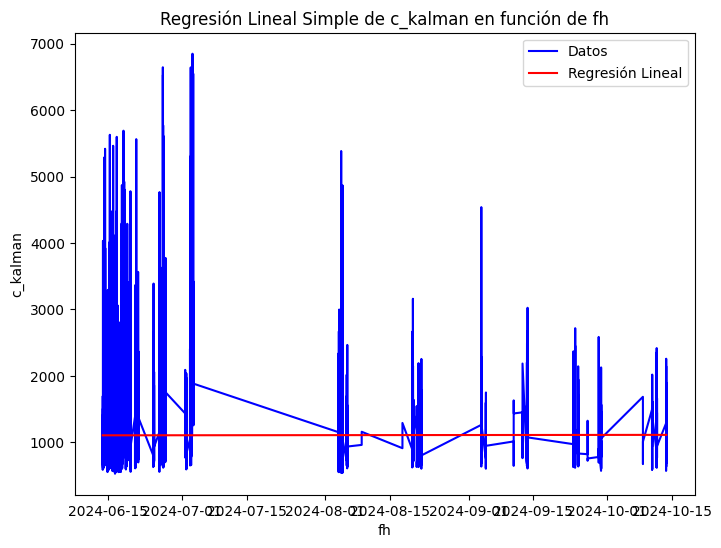

Regresión Lineal Simple para v_kalman:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 15 Oct 2024   Prob (F-statistic):                nan
Time:                        17:39:13   Log-Likelihood:            -2.6888e+05
No. Observations:               34917   AIC:                         5.378e+05
Df Residuals:                   34916   BIC:                         5.378e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

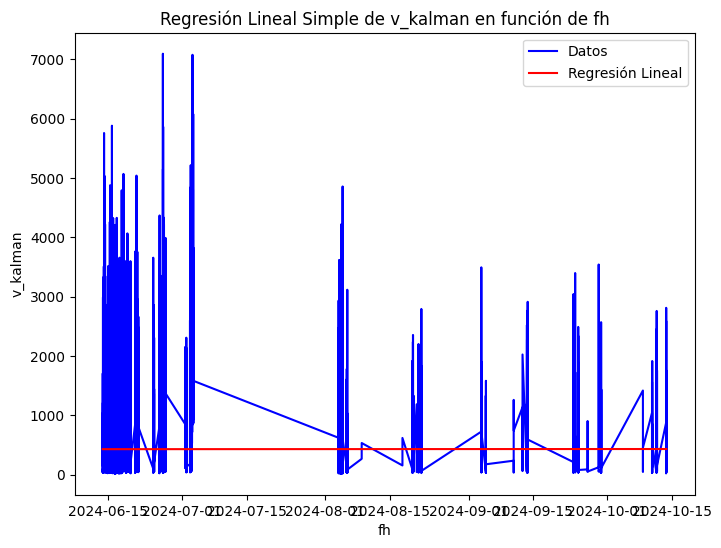

In [ ]:
import statsmodels.api as sm
import numpy as np

#Regresión lineal simple
# Aplicar el filtro de Kalman a cada columna
df['h_kalman'] = apply_kalman_filter(df['h'])
df['t_kalman'] = apply_kalman_filter(df['t'])
df['c_kalman'] = apply_kalman_filter(df['c'])
df['v_kalman'] = apply_kalman_filter(df['v'])

# Calcular el promedio de las variables por cada timestamp
g = df.groupby('fh')[['h_kalman', 't_kalman', 'c_kalman', 'v_kalman']].mean()
g = g.fillna(g.mean())
g = g.dropna()

# Aplicar regresión lineal simple a cada variable
for variable in ['h_kalman', 't_kalman', 'c_kalman', 'v_kalman']:
    y = g[variable].values
    X = g.index.astype(int).values.reshape(-1, 1)  # Usamos los timestamps convertidos a enteros como variable independiente
    X = sm.add_constant(X)

    model = sm.OLS(y, X)
    results = model.fit()

    print(f"Regresión Lineal Simple para {variable}:")
    print(results.summary())
    print("\n")

    # Gráfico de línea y línea de regresión
    plt.figure(figsize=(8, 6))
    plt.plot(g.index, g[variable], label='Datos', color='blue')
    plt.plot(g.index, results.predict(), color='red', label='Regresión Lineal')
    plt.title(f'Regresión Lineal Simple de {variable} en función de fh')
    plt.xlabel('fh')
    plt.ylabel(variable)
    plt.legend()
    plt.show()

1. Calidad del Ajuste:

    R-cuadrado (R-squared): 0.227 indica que el modelo explica el 22.7% de la variabilidad en la variable dependiente (y). Esto sugiere que el modelo tiene un ajuste moderadamente bajo.
    R-cuadrado Ajustado (Adj. R-squared): 0.226, lo que indica una pequeña penalización por el número de predictores en el modelo, pero no difiere mucho del R-cuadrado no ajustado, sugiriendo que los predictores son relevantes.

2. Significancia Global del Modelo:

    Estadístico F y Probabilidad: Un F-statistic de 1992 con una probabilidad asociada de 0.00 indica que el modelo es estadísticamente significativo, lo que significa que al menos uno de los predictores está significativamente relacionado con la variable dependiente.

3. Coeficientes de los Predictores:

    Constante (const): El coeficiente extremadamente alto (1.732×10181.732×1018) es inusual y podría indicar problemas de escalamiento o colinealidad en los datos.
    h_kalman: Un coeficiente de −2.345×1013−2.345×1013 sugiere que hay una relación inversa significativa entre h_kalman y la variable dependiente.
    t_kalman: Un coeficiente de −4.383×1014−4.383×1014 indica una fuerte relación inversa y significativa con la variable dependiente.
    c_kalman: Un coeficiente de 1.997×10111.997×1011 muestra una relación directa significativa con la variable dependiente.
    v_kalman: Un coeficiente de −1.409×1011−1.409×1011 indica una relación inversa significativa con la variable dependiente.

4. Diagnósticos de la Distribución de los Errores:

    Omnibus y Jarque-Bera: Ambos tests indican que los residuos no están distribuidos normalmente (p-valores de 0.000).
    Durbin-Watson: Un valor de 0.400 sugiere la presencia de autocorrelación positiva en los residuos.
    Skewness y Kurtosis: Skewness de 0.625 y kurtosis de 2.963 indican que la distribución de los residuos es moderadamente asimétrica y leptocúrtica, respectivamente.

Regresión Múltiple:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     1673.
Date:                Tue, 15 Oct 2024   Prob (F-statistic):               0.00
Time:                        17:39:20   Log-Likelihood:            -1.2846e+06
No. Observations:               34917   AIC:                         2.569e+06
Df Residuals:                   34912   BIC:                         2.569e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.774e+18   1.16e+15

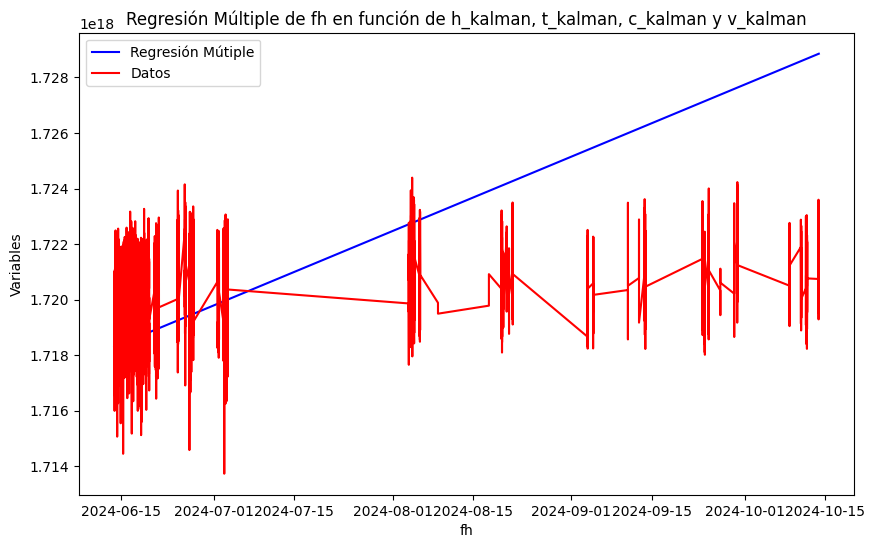

In [ ]:
# Aplicar regresión múltiple
y = g.index.astype(int).values.reshape(-1, 1)  # Usamos los timestamps convertidos a enteros como variable independiente
X = g[['h_kalman', 't_kalman', 'c_kalman', 'v_kalman']]
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()

print("Regresión Múltiple:")
print(results.summary())
print("\n")

# Gráfico de resultados
plt.figure(figsize=(10, 6))
plt.plot(g.index, y, label='Regresión Mútiple', color='blue')
plt.plot(g.index, results.predict(), color='red', label='Datos')
plt.title('Regresión Múltiple de fh en función de h_kalman, t_kalman, c_kalman y v_kalman')
plt.xlabel('fh')
plt.ylabel('Variables')
plt.legend()
plt.show()

El modelo de IAQ combina las variables de humedad, temperatura, CO2 y TVOC para proporcionar una medida compuesta de la calidad del aire. Se normalizan las variables filtradas, se le asigna un peso a cada variable, al normalizar estas variables, se asegura que cada una contribuya de manera efectiva al índice final, en este caso w_V=0.35, w_C=0.25, w_H=0.25 y w_T=0.15. Despues se multiplica la variable normalizada por su peso, finalmente se suma los valores restantes y se calcula el Índice de Calidad del Aire (IAQ) como el promedio de las variables normalizadas, dando un valor entre 0 y 1. El IAQ proporciona una medida compuesta de la calidad del aire basada en múltiples factores. La visualización del IAQ a lo largo del tiempo permite observar cómo varía la calidad del aire y qué factores pueden estar influyendo en ella.

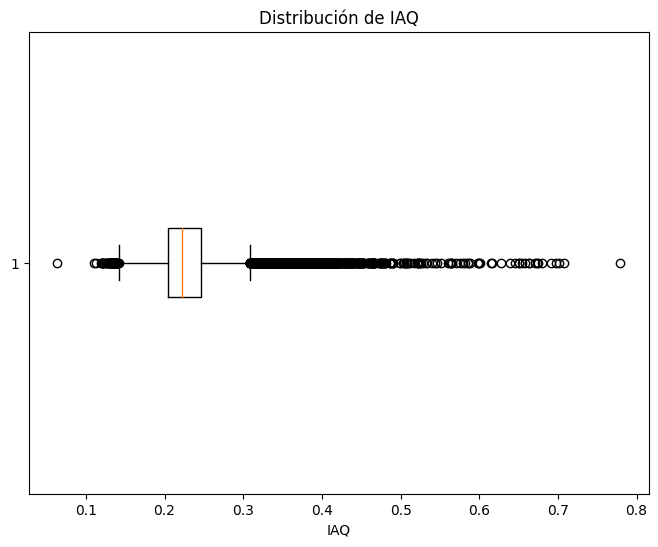


 Niveles IAQ 

0.0 - 0.2   Excelente
0.2 - 0.4   Bueno
0.4 - 0.6   Moderado
0.6 - 0.8   Malo
0.8 - 1.0   Muy Malo


Registros con IAQ calculado:
           c idDispositivo                  fh          t     v          h  \
2272   400.0  1C63B7F23A08 2024-06-13 19:03:41  28.400000   0.0  30.700001   
22967  400.0  1C63B7F23A08 2024-06-13 19:03:51  28.500000   0.0  30.700001   
19708  400.0  1C63B7F23A08 2024-06-13 19:05:04  28.799999   0.0  30.200001   
18036  400.0  1C63B7F23A08 2024-06-13 19:06:33  28.799999   0.0  30.200001   
32012  400.0  1C63B7F23A08 2024-06-13 19:06:43  28.799999   0.0  30.200001   
...      ...           ...                 ...        ...   ...        ...   
34752  874.0  1C63B7F23A08 2024-10-13 20:07:44  24.200001  65.0  42.200001   
10357  892.0  1C63B7F23A08 2024-10-13 20:08:24  24.200001  68.0  41.200001   
20456  935.0  1C63B7F23A08 2024-10-13 20:08:34  24.200001  74.0  41.200001   
20776  971.0  1C63B7F23A08 2024-10-13 20:08:44  24.200001  80.0  41.200001

In [ ]:
# Reiniciar el índice del DataFrame
df = df.reset_index(drop=True)

# Aplicar el filtro de Kalman a cada columna
df['h_kalman'] = apply_kalman_filter(df['h'])
df['t_kalman'] = apply_kalman_filter(df['t'])
df['c_kalman'] = apply_kalman_filter(df['c'])
df['v_kalman'] = apply_kalman_filter(df['v'])

# Normalizar las variables de Kalman
df['h_kalman_norm'] = (df['h_kalman'] - df['h_kalman'].min()) / (df['h_kalman'].max() - df['h_kalman'].min())
df['t_kalman_norm'] = (df['t_kalman'] - df['t_kalman'].min()) / (df['t_kalman'].max() - df['t_kalman'].min())
df['c_kalman_norm'] = (df['c_kalman'] - df['c_kalman'].min()) / (df['c_kalman'].max() - df['c_kalman'].min())
df['v_kalman_norm'] = (df['v_kalman'] - df['v_kalman'].min()) / (df['v_kalman'].max() - df['v_kalman'].min())

# Calcular el IAQ para cada registro
def normalize(value, min_value, max_value):
    return (value - min_value) / (max_value - min_value)

# Función para calcular el IAQ
def calculate_iaq(row, t_min, t_max, h_min, h_max, c_min, c_max, v_min, v_max):

    # Normalización de cada variable
    T_norm = normalize(row['t_kalman'], t_min, t_max)
    H_norm = normalize(row['h_kalman'], h_min, h_max)
    CO2_norm = normalize(row['c_kalman'], c_min, c_max)
    TVOC_norm = normalize(row['v_kalman'], v_min, v_max)

    # Asignación de pesos (puede modificarse según la importancia de cada variable)
    w_T, w_H, w_C, w_V = 0.15, 0.25, 0.25, 0.35

    # Cálculo del IAQ
    IAQ = (w_T * T_norm) + (w_H * H_norm) + (w_C * CO2_norm) + (w_V * TVOC_norm)

    # Asegurarse de que IAQ esté en el rango [0, 1]
    IAQ = min(max(IAQ, 0), 1)

    return IAQ

# Rango de valores mínimos y máximos para cada variable
t_min, t_max = df['t_kalman'].min(), df['t_kalman'].max()
h_min, h_max = df['h_kalman'].min(), df['h_kalman'].max()
c_min, c_max = df['c_kalman'].min(), df['c_kalman'].max()
v_min, v_max = df['v_kalman'].min(), df['v_kalman'].max()

# Calcular el IAQ para cada registro
df['IAQ'] = df.apply(lambda row: calculate_iaq(row, t_min, t_max, h_min, h_max, c_min, c_max, v_min, v_max), axis=1)

# Ordenar por 'fh'
df = df.sort_values(by='fh')

# Boxplot de IAQ
plt.figure(figsize=(8, 6))
plt.boxplot(df['IAQ'], vert=False)
plt.title('Distribución de IAQ')
plt.xlabel('IAQ')
plt.show()

print("\n Niveles IAQ \n")
print("0.0 - 0.2   Excelente")
print("0.2 - 0.4   Bueno")
print("0.4 - 0.6   Moderado")
print("0.6 - 0.8   Malo")
print("0.8 - 1.0   Muy Malo")
print("\n")

# Mostrar los registros
print("Registros con IAQ calculado:")
print(df)

Adicionalmente en el calculo del modelo se colocan los valores obtenidos dentro de una campana de gauss para mostrar de manera muy visual los colores de los niveles de las mediciones.

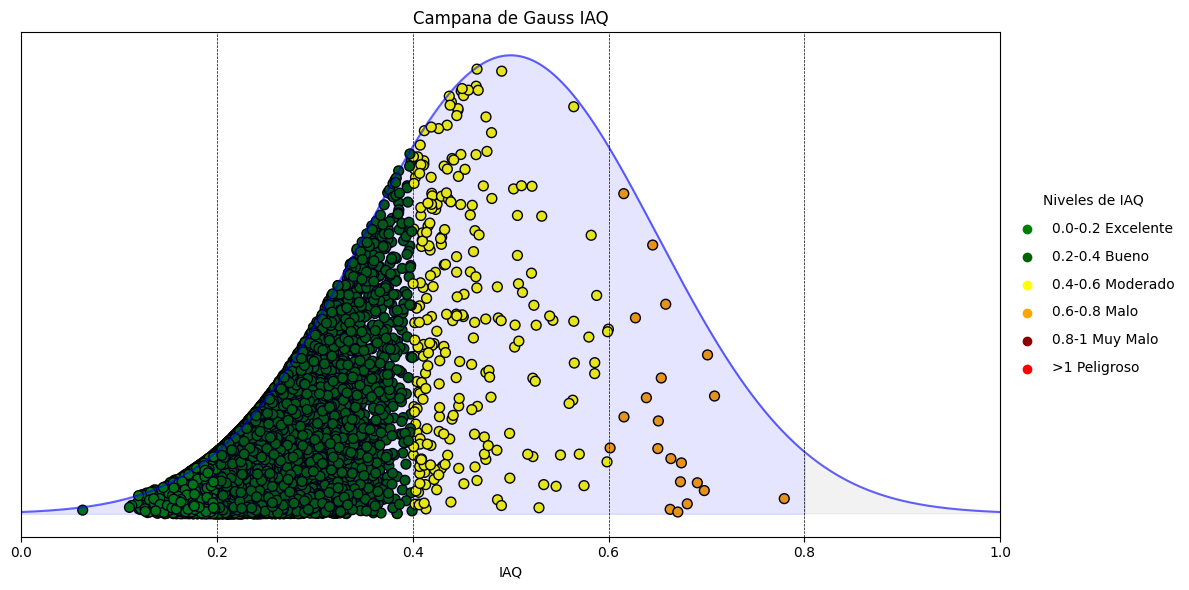

In [ ]:
from scipy.stats import norm
import seaborn as sns

df = df.sort_values(by='fh')

# Valores x para la campana de Gauss dentro del rango -0.2 a 1.2
x = np.linspace(-0.2, 1.2, 1600)  # Ampliamos el rango para hacer la campana más ancha
# Campana de Gauss con el rango ajustado
y = norm.pdf(x, 0.5, 0.15)

# Colores para los puntos de IAQ basados en los rangos especificados
colors = np.where(df['IAQ'] > 1, 'red',
                  np.where(df['IAQ'] > 0.8, 'darkred',
                           np.where(df['IAQ'] > 0.6, 'orange',
                                    np.where(df['IAQ'] > 0.4, 'yellow',
                                             np.where(df['IAQ'] > 0.2, 'darkgreen',
                                                      np.where(df['IAQ'] >= 0, 'green', 'gray'))))))

# Generar coordenadas y aleatorias para los puntos de IAQ dentro de la campana
np.random.seed(0)
y_points = np.random.uniform(0, norm.pdf(df['IAQ'], 0.5, 0.15))

# Gráfico de la campana de Gauss y los puntos de IAQ
plt.figure(figsize=(12, 6))  # Ajustamos el tamaño para incluir las anotaciones

# Gráfico principal: Campana de Gauss y puntos de IAQ
plt.plot(x, y, color='blue', alpha=0.6)  # Campana de Gauss
plt.scatter(df['IAQ'], y_points, c=colors, s=50, edgecolor='k')  # Puntos de IAQ
plt.fill_between(x, 0, y, where=(x >= -0.0) & (x <= 0.8), color='blue', alpha=0.1)  # Área de aceptación
plt.fill_between(x, 0, y, where=(x < 0) | (x > 0.8), color='gray', alpha=0.1)  # Área de rechazo
plt.axvline(x=0.2, color='black', linestyle='--', linewidth=0.5)  # Líneas de referencia
plt.axvline(x=0.4, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=0.6, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=0.8, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=1.0, color='black', linestyle='--', linewidth=0.5)
plt.title('Campana de Gauss IAQ')
plt.xlabel('IAQ')
plt.gca().axes.get_yaxis().set_visible(False)
plt.xlim([0, 1])

# Anotaciones de colores y etiquetas hacia la derecha (invertido)
levels = ['0.0-0.2 Excelente', '0.2-0.4 Bueno', '0.4-0.6 Moderado', '0.6-0.8 Malo', '0.8-1 Muy Malo', '>1 Peligroso']
colors = ['green', 'darkgreen', 'yellow', 'orange', 'darkred', 'red']

for level, color in zip(levels, colors):
    plt.scatter([], [], color=color, label=level, marker='o')  # Punto de muestra para etiqueta de color

plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Niveles de IAQ', loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()  # Ajustar el diseño para evitar superposiciones
plt.show()

Se utiliza 3 algoritmos para predecir h_kalman, t_kalman, c_kalman, v_kalman e IAQ. Las predicciones se comparan con los valores reales del IAQ, proporcionando una visualización clara de la efectividad de los modelos en la predicción del IAQ.
El primer algoritmo es el exponential smoothing, que es una técnica utilizada principalmente para series temporales. Este modelo es capaz de manejar tendencias y estacionalidades, proporcionando predicciones basadas en componentes aditivos o multiplicativos. En este caso, consta de 7 pasos en el entrenamiento de los datos para arrojar una predicción promedio por día, de 7 días en total.
Por otro lado, se aplica el modelo de Regresión de Bosque Aleatorio para predecir el IAQ basado en las variables normalizadas, se construyen múltiples árboles de decisión durante el entrenamiento, y cada árbol contribuye a la predicción final mediante un proceso de votación. Este enfoque ayuda a reducir el sobreajuste y mejora la capacidad del modelo para generalizar a nuevos datos. La predicción se compara con los valores reales del IAQ.
Adicionalmente se implementa un modelo de Máquinas de Vector Soporte (SVR) para predecir el IAQ. Este algoritmo busca encontrar un hiperplano que divida los datos en clases distintas con el máximo margen posible. Para la regresión, se utiliza el concepto de márgenes suaves para permitir cierto grado de error en las predicciones, maximizando la distancia entre los puntos de datos y el hiperplano de regresión.

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import warnings

# Función para normalizar datos
def normalize_series(series):
    return (series - np.mean(series)) / np.std(series)

#Suavizado exponencial
def exponential_smoothing_forecast(data, steps=7):
    data_normalized = normalize_series(data)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        fit = ExponentialSmoothing(data_normalized, seasonal_periods=7, trend='add', seasonal='add').fit(optimized=True)
    forecast_normalized = fit.forecast(steps)
    forecast = (forecast_normalized * np.std(data)) + np.mean(data)
    return forecast

# Predicción para cada variable de Kalman y IAQ
predictions_exp = {}
for variable in ['h_kalman', 't_kalman', 'c_kalman', 'v_kalman', "IAQ"]:
    data_series = df[variable].values
    prediction_exp = exponential_smoothing_forecast(data_series, steps=7)  # Cambiado a 7 días
    predictions_exp[variable] = prediction_exp
    print(f"\nPredicción de {variable} para los siguientes 7 días con Suavizado Exponencial:")
    for i, pred in enumerate(prediction_exp):
        date = df['fh'].max() + timedelta(days=i+1)
        print(f"  Fecha: {date.strftime('%Y/%m/%d')}, {variable}: {pred}")

print("\nNiveles IAQ \n")
print("0.0 - 0.2   Excelente")
print("0.2 - 0.4   Bueno")
print("0.4 - 0.6   Moderado")
print("0.6 - 0.8   Malo")
print("0.8 - 1.0   Muy Malo")
print("\n")


Predicción de h_kalman para los siguientes 7 días con Suavizado Exponencial:
  Fecha: 2024/10/14, h_kalman: 41.95826274667186
  Fecha: 2024/10/15, h_kalman: 41.99612360250941
  Fecha: 2024/10/16, h_kalman: 41.98294570723288
  Fecha: 2024/10/17, h_kalman: 41.96722058339044
  Fecha: 2024/10/18, h_kalman: 41.995691668897635
  Fecha: 2024/10/19, h_kalman: 41.99523940630135
  Fecha: 2024/10/20, h_kalman: 42.02658541498992

Predicción de t_kalman para los siguientes 7 días con Suavizado Exponencial:
  Fecha: 2024/10/14, t_kalman: 26.586851003320348
  Fecha: 2024/10/15, t_kalman: 26.569235282679816
  Fecha: 2024/10/16, t_kalman: 26.574187615638767
  Fecha: 2024/10/17, t_kalman: 26.58253126702763
  Fecha: 2024/10/18, t_kalman: 26.574118269411123
  Fecha: 2024/10/19, t_kalman: 26.57385590659827
  Fecha: 2024/10/20, t_kalman: 26.572451710333834

Predicción de c_kalman para los siguientes 7 días con Suavizado Exponencial:
  Fecha: 2024/10/14, c_kalman: 1017.7783203964143
  Fecha: 2024/10/15, c_k

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta


# Random Forest y Predicción
def random_forest_forecast(data, steps=7, noise_level=0.01):
    X = np.arange(len(data)).reshape(-1, 1)
    y = data

    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Inicializar el modelo de Random Forest
    model = RandomForestRegressor(random_state=42, n_estimators=100)

    # Ajustar el modelo
    model.fit(X_train, y_train)

    # Predecir los siguientes 'steps' días
    forecast_index = np.arange(len(data), len(data) + steps).reshape(-1, 1)
    forecast = model.predict(forecast_index)

    # Añadir ruido aleatorio a las predicciones
    noise = np.random.normal(0, noise_level, steps)
    forecast_with_noise = forecast + noise

    return forecast_with_noise

# Predicción para cada variable de Kalman y IAQ utilizando Random Forest
predictions_rf = {}
for variable in ['h_kalman', 't_kalman', 'c_kalman', 'v_kalman', 'IAQ']:
    data_series = df[variable].values
    prediction_rf = random_forest_forecast(data_series, steps=7)
    predictions_rf[variable] = prediction_rf
    print(f"\nPredicción de {variable} para los siguientes 14 días con Random Forest:")
    for i, pred in enumerate(prediction_rf):
        date = df['fh'].max() + timedelta(days=i+1)
        print(f"  Fecha: {date.strftime('%Y/%m/%d')}, {variable}: {pred}")

print("\nNiveles IAQ \n")
print("0.0 - 0.2   Excelente")
print("0.2 - 0.4   Bueno")
print("0.4 - 0.6   Moderado")
print("0.6 - 0.8   Malo")
print("0.8 - 1.0   Muy Malo")
print("\n")


Predicción de h_kalman para los siguientes 14 días con Random Forest:
  Fecha: 2024/07/02, h_kalman: 48.45340993796269
  Fecha: 2024/07/03, h_kalman: 48.47500834045858
  Fecha: 2024/07/04, h_kalman: 48.47870011348813
  Fecha: 2024/07/05, h_kalman: 48.46804635748598
  Fecha: 2024/07/06, h_kalman: 48.476139843153526
  Fecha: 2024/07/07, h_kalman: 48.47375419910778
  Fecha: 2024/07/08, h_kalman: 48.4651166271962

Predicción de t_kalman para los siguientes 14 días con Random Forest:
  Fecha: 2024/07/02, t_kalman: 26.78724637140362
  Fecha: 2024/07/03, t_kalman: 26.80756926848396
  Fecha: 2024/07/04, t_kalman: 26.820808551893954
  Fecha: 2024/07/05, t_kalman: 26.790053701300714
  Fecha: 2024/07/06, t_kalman: 26.797619761369447
  Fecha: 2024/07/07, t_kalman: 26.779311754373346
  Fecha: 2024/07/08, t_kalman: 26.79782754114562

Predicción de c_kalman para los siguientes 14 días con Random Forest:
  Fecha: 2024/07/02, c_kalman: 764.3731735187708
  Fecha: 2024/07/03, c_kalman: 764.4060147267917

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR

# Vector Support Machines y Predicción
def svm_forecast(data, steps=7):
    X = np.arange(len(data)).reshape(-1, 1)
    y = data

    # Dividir los datos en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Inicializar el modelo de SVM
    model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)

    # Ajustar el modelo
    model.fit(X_train, y_train)

    # Predecir los siguientes steps días
    forecast = model.predict(np.arange(len(data), len(data) + steps).reshape(-1, 1))

    return forecast

# Predicción para cada variable de Kalman y IAQ utilizando SVM
predictions_svm = {}
for variable in ['h_kalman', 't_kalman', 'c_kalman', 'v_kalman', 'IAQ']:
    data_series = df[variable].values
    prediction_svm = svm_forecast(data_series, steps=7)
    predictions_svm[variable] = prediction_svm
    print(f"\nPredicción de {variable} para los siguientes 7 días con SVM:")
    for i, pred in enumerate(prediction_svm):
        date = df['fh'].max() + timedelta(days=i+1)
        print(f"  Fecha: {date.strftime('%Y/%m/%d')}, {variable}: {pred}")

print("\nNiveles IAQ \n")
print("0.0 - 0.2   Excelente")
print("0.2 - 0.4   Bueno")
print("0.4 - 0.6   Moderado")
print("0.6 - 0.8   Malo")
print("0.8 - 1.0   Muy Malo")
print("\n")


Predicción de h_kalman para los siguientes 7 días con SVM:
  Fecha: 2024/07/02, h_kalman: 47.33640431894386
  Fecha: 2024/07/03, h_kalman: 45.63346505904559
  Fecha: 2024/07/04, h_kalman: 43.72707516519411
  Fecha: 2024/07/05, h_kalman: 42.189179675397945
  Fecha: 2024/07/06, h_kalman: 41.250412646461825
  Fecha: 2024/07/07, h_kalman: 40.805242046838735
  Fecha: 2024/07/08, h_kalman: 40.63863883600268

Predicción de t_kalman para los siguientes 7 días con SVM:
  Fecha: 2024/07/02, t_kalman: 27.044344404052804
  Fecha: 2024/07/03, t_kalman: 27.262691505760674
  Fecha: 2024/07/04, t_kalman: 27.484887755991476
  Fecha: 2024/07/05, t_kalman: 27.652027531939158
  Fecha: 2024/07/06, t_kalman: 27.748773387662307
  Fecha: 2024/07/07, t_kalman: 27.792799100496403
  Fecha: 2024/07/08, t_kalman: 27.808751065508517

Predicción de c_kalman para los siguientes 7 días con SVM:
  Fecha: 2024/07/02, c_kalman: 809.1719728023222
  Fecha: 2024/07/03, c_kalman: 838.5488002216541
  Fecha: 2024/07/04, c_kal

En esta sección, se evalúan los tres algoritmos de predicción: Exponential Smoothing, Random Forest y Support Vector Machines (SVM).

Predicción y Evaluación

Para cada variable (h_kalman, t_kalman, c_kalman, v_kalman, IAQ), se realizan las siguientes operaciones:

División de Datos: Los datos se dividen en conjuntos de entrenamiento y prueba usando train_test_split.

Predicción: Se generan predicciones utilizando cada uno de los tres algoritmos.

Evaluación: Se calculan las métricas de rendimiento para las predicciones de cada algoritmo.

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Función para calcular métricas de evaluación
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mae, mape

# Predicción y evaluación para cada variable utilizando diferentes algoritmos
metrics = {'exponential_smoothing': {}, 'random_forest': {}, 'svm': {}}

for variable in ['h_kalman', 't_kalman', 'c_kalman', 'v_kalman', 'IAQ']:
    data_series = df[variable].values
    train_data, test_data = train_test_split(data_series, test_size=0.2, random_state=42)

    # Exponential Smoothing
    prediction_exp = exponential_smoothing_forecast(train_data, steps=len(test_data))
    mae_exp, mape_exp = evaluate_forecast(test_data, prediction_exp)
    metrics['exponential_smoothing'][variable] = {'MAE': mae_exp, 'MAPE': mape_exp}

    # Random Forest
    prediction_rf = random_forest_forecast(train_data, steps=len(test_data))
    mae_rf, mape_rf = evaluate_forecast(test_data, prediction_rf)
    metrics['random_forest'][variable] = {'MAE': mae_rf, 'MAPE': mape_rf}

    # SVM
    prediction_svm = svm_forecast(train_data, steps=len(test_data))
    mae_svm, mape_svm = evaluate_forecast(test_data, prediction_svm)
    metrics['svm'][variable] = {'MAE': mae_svm, 'MAPE': mape_svm}

    print(f"\nEvaluación de {variable} con diferentes algoritmos:")
    print("Exponential Smoothing: MAE =", mae_exp, "MAPE =", mape_exp)
    print("Random Forest: MAE =", mae_rf, "MAPE =", mape_rf)
    print("SVM: MAE =", mae_svm, "MAPE =", mape_svm)



Evaluación de h_kalman con diferentes algoritmos:
Exponential Smoothing: MAE = 3.404374224497796 MAPE = 0.08944835610224101
Random Forest: MAE = 4.3472725840406685 MAPE = 0.11800193147028841
SVM: MAE = 3.4573988445950836 MAPE = 0.08950508198147172

Evaluación de t_kalman con diferentes algoritmos:
Exponential Smoothing: MAE = 4.809431654760368 MAPE = 0.1750939953846163
Random Forest: MAE = 1.077335155482385 MAPE = 0.038526163897808385
SVM: MAE = 0.8685544144915913 MAPE = 0.03163693631625776

Evaluación de c_kalman con diferentes algoritmos:
Exponential Smoothing: MAE = 416.07439830181903 MAPE = 0.510584441476446
Random Forest: MAE = 407.4689088755256 MAPE = 0.3818241048561722
SVM: MAE = 406.85428750869187 MAPE = 0.44044264991788273

Evaluación de v_kalman con diferentes algoritmos:
Exponential Smoothing: MAE = 103.68539229127072 MAPE = 148222933387905.88
Random Forest: MAE = 102.4563739734358 MAPE = 80941262871323.19
SVM: MAE = 103.37796750387592 MAPE = 130490859832574.28

Evaluación 

Evaluación de h_kalman

Exponential Smoothing:
        MAE (Mean Absolute Error): 3.404
        MAPE (Mean Absolute Percentage Error): 0.089 (8.9%)

El error absoluto medio es relativamente bajo, indicando que el modelo de suavizado exponencial se aproxima bastante bien a los valores reales. El MAPE sugiere que, en promedio, las predicciones del modelo difieren de los valores reales en un 8.9%.

Random Forest:
        MAE: 4.347
        MAPE: 0.118 (11.8%)

El MAE es más alto que el de Exponential Smoothing, lo que indica un error absoluto medio mayor. El MAPE de 11.8% muestra que las predicciones tienden a desviarse más de los valores reales en comparación con el modelo de suavizado exponencial.

SVM (Support Vector Machines):
        MAE: 3.457
        MAPE: 0.089 (8.9%)

El SVM tiene un MAE ligeramente mayor que el de Exponential Smoothing, pero el MAPE es el mismo, lo que sugiere que ambos modelos tienen una precisión similar en términos de porcentaje.

Evaluación de t_kalman

Exponential Smoothing:
        MAE: 4.809
        MAPE: 0.175 (17.5%)

Un MAE relativamente alto indica un error absoluto medio significativo. El MAPE de 17.5% muestra una variabilidad considerable en las predicciones.

Random Forest:
        MAE: 1.077
        MAPE: 0.039 (3.9%)

Un MAE mucho más bajo que el de Exponential Smoothing indica que Random Forest se ajusta mejor a los datos. El MAPE de 3.9% sugiere que las predicciones son bastante precisas.

SVM:
        MAE: 0.869
        MAPE: 0.032 (3.2%)

SVM muestra el MAE más bajo entre los tres algoritmos, indicando un error absoluto medio menor. El MAPE de 3.2% es también el más bajo, lo que sugiere la mayor precisión relativa en las predicciones.

Evaluación de c_kalman

Exponential Smoothing:
        MAE: 416.074
        MAPE: 0.511 (51.1%)

Un MAE muy alto indica grandes errores absolutos medios en las predicciones. El MAPE de 51.1% sugiere una gran variabilidad y errores significativos.

Random Forest:
        MAE: 407.469
        MAPE: 0.382 (38.2%)

Aunque el MAE sigue siendo alto, es ligeramente menor que el de Exponential Smoothing. El MAPE de 38.2% muestra una mejora en la precisión relativa.

SVM:
        MAE: 406.854
        MAPE: 0.440 (44.0%)

El MAE más bajo entre los tres algoritmos, pero el MAPE sugiere que aún hay una considerable variabilidad en las predicciones, aunque menor que en Exponential Smoothing.

Evaluación de v_kalman

Exponential Smoothing:
        MAE: 103.685
        MAPE: 148222933387905.88 (impreciso debido a errores de cálculo)

El MAE sugiere grandes errores absolutos medios. El MAPE es extremadamente alto y parece ser erróneo, indicando problemas en el cálculo o en los datos.

Random Forest:
        MAE: 102.456
        MAPE: 80941262871323.19 (impreciso debido a errores de cálculo)

Similar al Exponential Smoothing, el MAE es alto y el MAPE es nuevamente erróneo.

SVM:
        MAE: 103.378
        MAPE: 130490859832574.28 (impreciso debido a errores de cálculo)

MAE similar a los otros modelos y el MAPE también parece erróneo.

Evaluación de IAQ

Exponential Smoothing:
        MAE: 0.027
        MAPE: 0.132 (13.2%)

  Un MAE bajo indica errores absolutos medios pequeños. El MAPE de 13.2% muestra una precisión razonable.

  Random Forest:
        MAE: 0.028
        MAPE: 0.142 (14.2%)

El MAE es ligeramente mayor que en Exponential Smoothing, lo que indica errores absolutos medios un poco mayores. El MAPE de 14.2% sugiere una precisión ligeramente inferior.

SVM:
        MAE: 0.026
        MAPE: 0.134 (13.4%)

El MAE más bajo entre los tres algoritmos indica los errores absolutos medios más pequeños. El MAPE de 13.4% es similar al de Exponential Smoothing, sugiriendo una precisión comparable.

Conclusión:

Los resultados arrojan que en general, los algoritmos de Random Forest y SVM tienden a proporcionar predicciones más precisas en términos de MAE y MAPE comparados con Exponential Smoothing, especialmente para las variables t_kalman e IAQ. Sin embargo, para h_kalman y c_kalman, las diferencias son menos significativas y todos los algoritmos presentan ciertos desafíos en términos de precisión.

Para finalizar, se desarrolla un histograma sobre el IAQ, que nos muestra cual es el rango más común de esta variable.


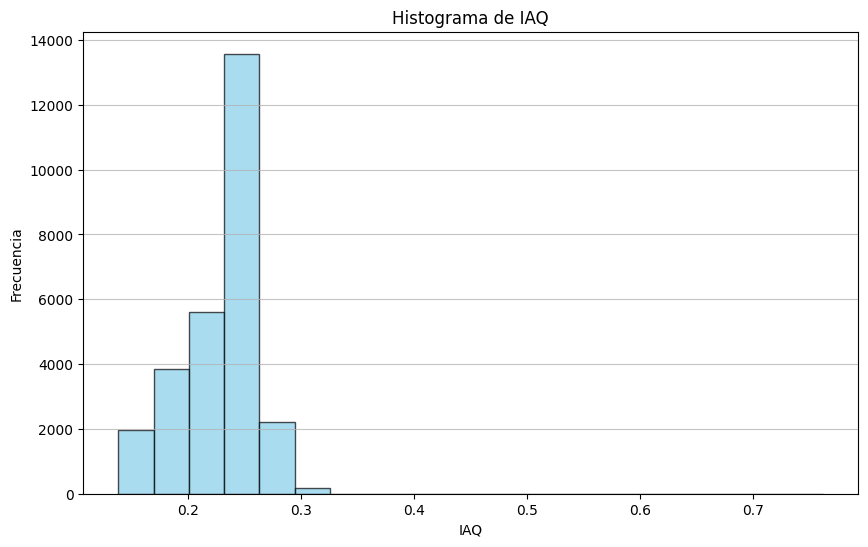

In [ ]:
# Histograma de IAQ
plt.figure(figsize=(10, 6))
plt.hist(df['IAQ'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histograma de IAQ')
plt.xlabel('IAQ')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.show()